# Import of data for location based covid prediction and zoning the address

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import requests
import json
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
#df_covid_current_states=pd.read_csv('https://covidtracking.com/api/v1/states/current.csv')
#df_covid_current_states_updated=df_covid_current_states[['state','positive',]]
#print(df_covid_current_states.head())
#df_state_geo = pd.read_csv('https://raw.githubusercontent.com/kelvins/US-Cities-Database/master/csv/us_cities.csv')
#print(df_state_geo.head())
data_json=requests.get(url = 'https://www.trackcorona.live/api/cities').json()
df_states = pd.read_json(json.dumps(data_json['data']))
print(df_states)
df_states_needed = df_states[['latitude','longitude','confirmed','dead', 'recovered']]
#df_states_needed = df_states[['latitude','longitude','confirmed']]
#df_covid_current_states = pd.read_json(d)
df_states_needed.head()

                            location country_code   latitude   longitude  \
0             Wibaux County, Montana           us  46.783665 -104.318390   
1              Todd County, Kentucky           us  36.833864  -87.142289   
2                        Pilõezinhos           br  -6.843131  -35.530578   
3                            Pavussu           br  -7.964325  -43.224345   
4       Adjuntas County, Puerto Rico           us  18.163485  -66.723158   
...                              ...          ...        ...         ...   
9892      Tuscaloosa County, Alabama           us  33.322765  -87.460397   
9893        Washita County, Oklahoma           us  35.323403  -98.924534   
9894             Rush County, Kansas           us  38.535897  -99.278558   
9895  Harnett County, North Carolina           us  35.357865  -78.883555   
9896          White County, Illinois           us  38.050114  -88.246118   

      confirmed  dead  recovered  velocity_confirmed  velocity_dead  \
0             1 

,latitude,longitude,confirmed,dead,recovered
0,46.783665,-104.318390,1,0.0,NaN
1,36.833864,-87.142289,31,0.0,NaN
2,-6.843131,-35.530578,87,0.0,NaN
3,-7.964325,-43.224345,2,1.0,NaN
4,18.163485,-66.723158,82,0.0,NaN


# EDA of data for location based covid prediction and zoning the address

In [5]:
#EDA
df_states_needed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9897 entries, 0 to 9896
Data columns (total 5 columns):
latitude     9897 non-null float64
longitude    9897 non-null float64
confirmed    9897 non-null int64
dead         9651 non-null float64
recovered    1239 non-null float64
dtypes: float64(4), int64(1)
memory usage: 386.7 KB


In [112]:
print(df_states_needed.describe())
print(df_states_needed.isnull().sum())

          latitude    longitude      confirmed          dead     recovered
count  9897.000000  9897.000000    9897.000000   9651.000000   1256.000000
mean     13.905098   -43.661826     907.676670     42.099161   1166.102707
std      28.990097    52.431107    5850.528005    403.173482   4326.110362
min     -52.368047  -174.159607       0.000000      0.000000      0.000000
25%     -15.233475   -82.993161      10.000000      0.000000      4.750000
50%      25.355684   -49.012425      53.000000      1.000000     31.000000
75%      39.807989   -37.151764     301.000000      7.000000    342.500000
max      70.071821   171.695216  225148.000000  23531.000000  73402.000000
latitude        0
longitude       0
confirmed       0
dead          246
recovered    8641
dtype: int64


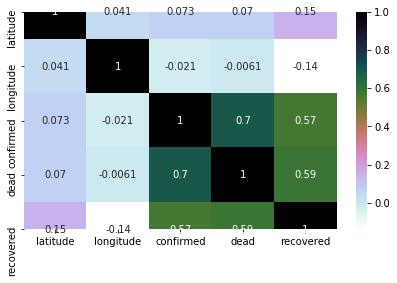

In [6]:
df_states_needed.fillna(0)
plt.figure(figsize=(7,4))
sns.heatmap(df_states_needed.corr(),annot=True,cmap='cubehelix_r')#draws heatmap with input as the correlation matrix calculated by (iris_data.corr())
plt.show()

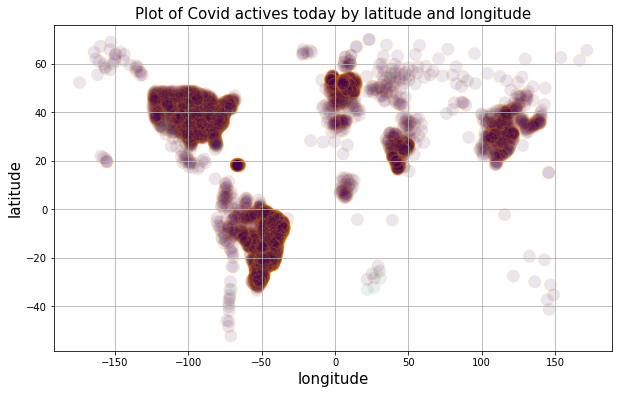

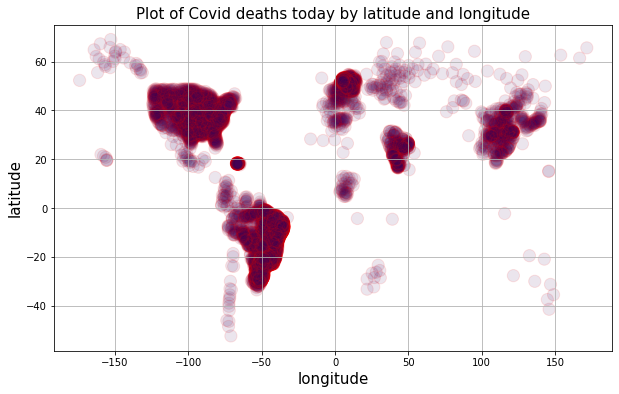

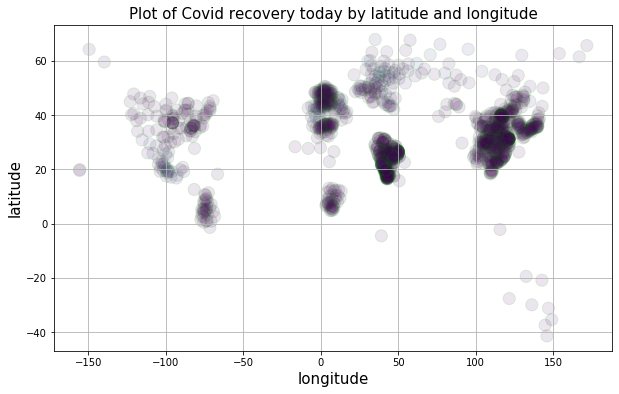

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['confirmed'],edgecolors='orange',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid actives today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['dead'],edgecolors='red',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid deaths today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['recovered'],edgecolors='green',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid recovery today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()


# KDD for predicting location based covid prediction and zoning the address

In [8]:
#ML to find covid index for a given geographic location

from sklearn.model_selection import train_test_split
X=df_states_needed[['latitude','longitude']]
#y=df_states_needed['confirmed']
y=df_states_needed[['confirmed','dead','recovered']].fillna(0)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(7917, 2)
(1980, 2)


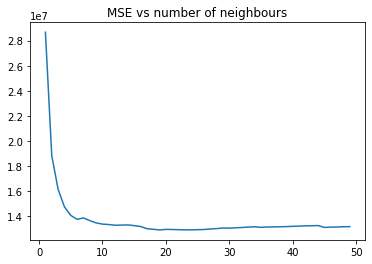

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
a=[]
c=[]
for n_value in  range(1,50):
    knnr = KNeighborsRegressor(n_neighbors = n_value)
    knnr.fit(X_train, y_train)
    a.append(n_value)
    #plt.scatter(x=n_value,y=format(np.power(y_test-knnr.predict(X_test),2).mean()),s=60,c='red')
    #print ("The MSE is:",mean_squared_error(y_test,knnr.predict(X_test))," ",n_value)
    c.append(mean_squared_error(y_test,knnr.predict(X_test)))
plt.plot(a,c)
plt.title("MSE vs number of neighbours")
plt.show()

In [10]:
params = {'n_neighbors': list(range(2,10))}
knnr = KNeighborsRegressor()
model = GridSearchCV(knnr, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

{'n_neighbors': 8}

In [106]:
#addressSearch = "277 communipaw ave jersey city new jersey 07205"
#addressSearch = "South Toe, NC 28714"
#addressSearch = "1255 E University Dr. Tempe | AZ 85281-4950"
#addressSearch = "balaji place cary"
#addressSearch = "green gables heritage place"
#addressSearch = "3170 bethel road columbus ohio"
#addressSearch = "2572 crescent view drive"
#addressSearch = "navaho arizona"
#addressSearch = "point loma san diego"
# addressSearch = "murphy NC"
addressSearch = "9309 Kittansett Dr NC 28262"

#addressSearch="3530 Alister ave sw concord 28027"

from sklearn.neighbors import KNeighborsRegressor
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="addresscodingLatLong")
location = geolocator.geocode(addressSearch)

location_string = str(location.latitude) + ", " + str(location.longitude)
location_given = geolocator.reverse(location_string)

stateOfData = location_given.raw.get('address').get('state')
countyOfData = location_given.raw.get('address').get('county')
print(countyOfData)

county_data = countyOfData.replace('County','').strip()
print(county_data)

knnr = KNeighborsRegressor(n_neighbors = model.best_params_.get('n_neighbors'))
knnr.fit(X_train, y_train)
print("Your coordinates are ",location.latitude,location.longitude)
covid_prediction=knnr.predict([[location.latitude,location.longitude]])
print("Todays covid confirmed index based on your location is - ", round(covid_prediction[0][0]))
print("Todays covid deaths index based on your location is - ", round(covid_prediction[0][1]))
#print("Todays covid recovery index based on your location is - ", round(covid_prediction[0][2]))

confirmed_numbers=arr = df_states_needed['confirmed'].to_numpy()[df_states_needed['confirmed'].to_numpy() != 0]
redvalue=np.percentile(confirmed_numbers, 95)
yellowvalue=np.percentile(confirmed_numbers, 75)
greenvalue=np.percentile(confirmed_numbers, 55)

def returnZone(covid_prediction):
    if covid_prediction>redvalue:
        return "Red Zone"
    elif covid_prediction>yellowvalue:
        return "Yellow Zone"
    else:
        return "Green Zone"



print("You are in ", returnZone(covid_prediction[0][0]))

Mecklenburg County
Mecklenburg
Your coordinates are  35.31543927839599 -80.74129504861425
Todays covid confirmed index based on your location is -  4272.0
Todays covid deaths index based on your location is -  51.0
You are in  Red Zone


# Import of data for time series predictions - this is to predict the future active rates at address of interest based on trend in state

In [107]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [108]:
df_covid19_county = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

# EDA of data for time series predictions - this is to predict the future active rates at address of interest based on trend in state

In [109]:
df_covid19_county.tail()

,date,county,state,fips,cases,deaths
389197,2020-07-31,Sweetwater,Wyoming,56037.0,240,2
389198,2020-07-31,Teton,Wyoming,56039.0,335,1
389199,2020-07-31,Uinta,Wyoming,56041.0,254,1
389200,2020-07-31,Washakie,Wyoming,56043.0,47,5
389201,2020-07-31,Weston,Wyoming,56045.0,5,0


In [37]:
grouping = df_covid19_county[df_covid19_county['date']=='2020-07-30']

print(grouping)

              date      county    state     fips  cases  deaths
382767  2020-07-30     Autauga  Alabama   1001.0   1002      21
382768  2020-07-30     Baldwin  Alabama   1003.0   3028      21
382769  2020-07-30     Barbour  Alabama   1005.0    585       5
382770  2020-07-30        Bibb  Alabama   1007.0    352       2
382771  2020-07-30      Blount  Alabama   1009.0    731       3
...            ...         ...      ...      ...    ...     ...
385980  2020-07-30  Sweetwater  Wyoming  56037.0    237       2
385981  2020-07-30       Teton  Wyoming  56039.0    331       1
385982  2020-07-30       Uinta  Wyoming  56041.0    247       1
385983  2020-07-30    Washakie  Wyoming  56043.0     45       5
385984  2020-07-30      Weston  Wyoming  56045.0      5       0

[3218 rows x 6 columns]


              date         county          state     fips   cases  deaths
384619  2020-07-30  New York City       New York      NaN  229551   22996
383377  2020-07-30           Cook       Illinois  17031.0  104691    4872
382970  2020-07-30    Los Angeles     California   6037.0  185872    4552
384084  2020-07-30          Wayne       Michigan  26163.0   26949    2800
384618  2020-07-30         Nassau       New York  36059.0   43158    2706
384543  2020-07-30          Essex     New Jersey  34013.0   19684    2100
384638  2020-07-30        Suffolk       New York  36103.0   43170    2043
384538  2020-07-30         Bergen     New Jersey  34003.0   20667    2040
382868  2020-07-30       Maricopa        Arizona   4013.0  114852    2011
383995  2020-07-30      Middlesex  Massachusetts  25017.0   25617    1974


<BarContainer object of 10 artists>

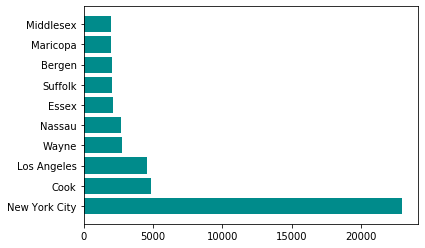

In [110]:
df = grouping.nlargest(10,'deaths')
print(df)
plt.barh(df['county'],df['deaths'],color="darkcyan")

In [111]:
state = (df_covid19_county['state'] ==stateOfData)
df_state = df_covid19_county.loc[state]

county = (df_state['county']== county_data)
df_county = df_state.loc[county]
print(df_county.head())
print(county_data)
print(stateOfData)

            date       county           state     fips  cases  deaths
1532  2020-03-12  Mecklenburg  North Carolina  37119.0      2       0
1826  2020-03-13  Mecklenburg  North Carolina  37119.0      2       0
2180  2020-03-14  Mecklenburg  North Carolina  37119.0      2       0
2592  2020-03-15  Mecklenburg  North Carolina  37119.0      4       0
3054  2020-03-16  Mecklenburg  North Carolina  37119.0      4       0
Mecklenburg
North Carolina


# Prediction using Active Cases in a state Using ARIMA for timeseries

In [112]:
df_county['active_count'] = df_county.cases.diff()

In [113]:
print(df_county['active_count'].sum())

20500.0


In [114]:
df_active = df_county[['date','active_count']].copy()

print(df_active)

              date  active_count
1532    2020-03-12           NaN
1826    2020-03-13           0.0
2180    2020-03-14           0.0
2592    2020-03-15           2.0
3054    2020-03-16           0.0
...            ...           ...
375057  2020-07-27         212.0
378273  2020-07-28         227.0
381490  2020-07-29         217.0
384708  2020-07-30         337.0
387925  2020-07-31         241.0

[142 rows x 2 columns]


In [115]:
df_active['date']=pd.to_datetime(df_active['date'])

df_active.set_index('date',inplace = True)

In [116]:
df_active['active_count'] = df_active['active_count'].fillna(0)

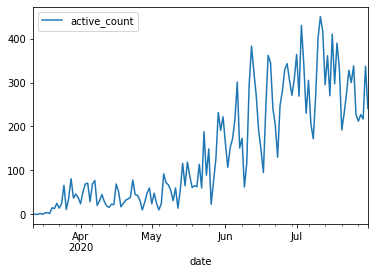

In [117]:
df_active.plot()

In [118]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

active_result=adfuller(df_active['active_count'])

In [119]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test_active(active_count):
    result_active=adfuller(active_count)
    labels_active = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result_active,labels_active):
        print(label+' : '+str(value) )
    if result_active[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [120]:
adfuller_test_active(df_active['active_count'])

ADF Test Statistic : -0.9068443782751423
p-value : 0.7857101099450311
#Lags Used : 6
Number of Observations Used : 135
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


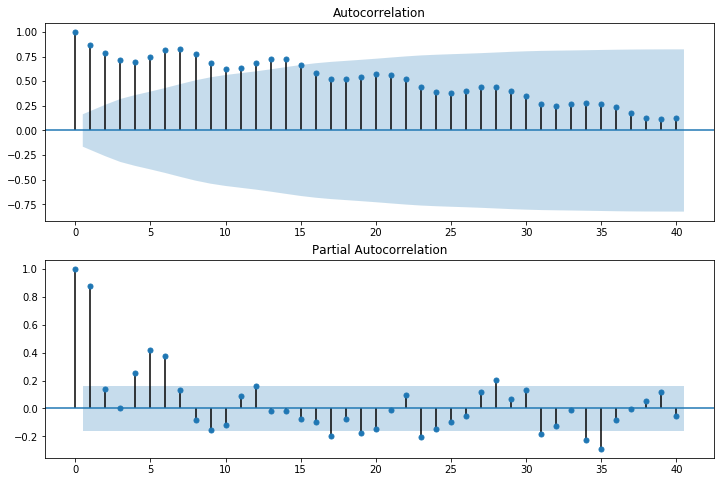

In [121]:
fig1 = plt.figure(figsize=(12,8))
ax1_1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(df_active['active_count'],lags=40,ax=ax1_1)
ax2_1 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(df_active['active_count'],lags=40,ax=ax2_1)

In [122]:
print(df_active['active_count'])
from statsmodels.tsa.arima_model import ARIMA
model_active=ARIMA(df_active['active_count'],order=(5,0,4))
model_fit_active=model_active.fit()

date
2020-03-12      0.0
2020-03-13      0.0
2020-03-14      0.0
2020-03-15      2.0
2020-03-16      0.0
              ...  
2020-07-27    212.0
2020-07-28    227.0
2020-07-29    217.0
2020-07-30    337.0
2020-07-31    241.0
Name: active_count, Length: 142, dtype: float64


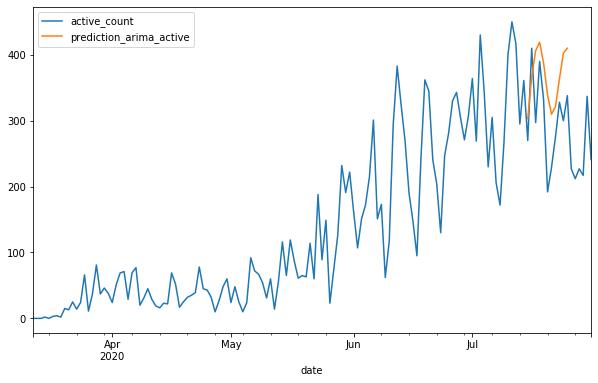

In [124]:
df_active['prediction_arima_active']=model_fit_active.predict(start=125,end=135,dynamic=True)
df_active[['active_count','prediction_arima_active']].plot(figsize=(10,6))

In [125]:
from pandas.tseries.offsets import DateOffset
add_dates_active = [df_active.index[-1]+DateOffset(days=x) for x in range(0,10)]

future_dates_active = pd.DataFrame(index=add_dates_active[1:],columns=df_active.columns)

In [126]:
future_dates_active.head() 

,active_count,prediction_arima_active
2020-08-01,NaN,NaN
2020-08-02,NaN,NaN
2020-08-03,NaN,NaN
2020-08-04,NaN,NaN
2020-08-05,NaN,NaN


In [127]:
future_df_active_ar=pd.concat([df_active,future_dates_active])

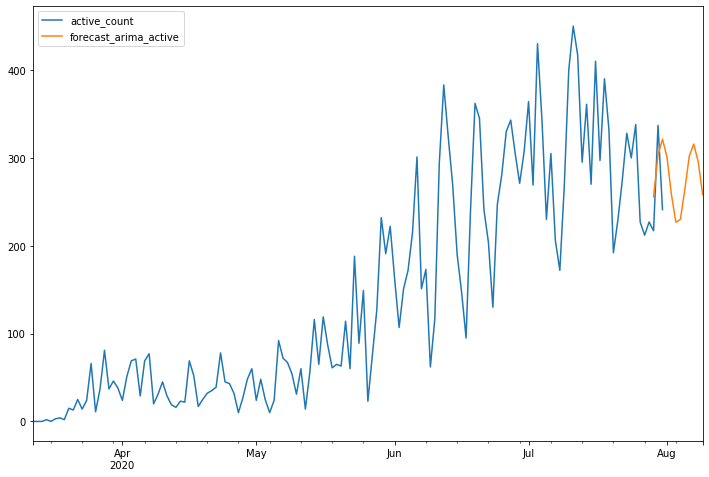

In [129]:
future_df_active_ar['forecast_arima_active'] = model_fit_active.predict(start = 139, end = 150, dynamic= True)  
future_df_active_ar[['active_count', 'forecast_arima_active']].plot(figsize=(12, 8))

In [131]:
#since we have used 10 in arima model to predict 10 days into future first row will always be current date
future_df_active_ar['forecast_arima_active'].tail(10)

2020-07-31    321.333019
2020-08-01    300.951438
2020-08-02    258.237169
2020-08-03    226.740033
2020-08-04    229.753871
2020-08-05    263.794512
2020-08-06    302.097134
2020-08-07    315.749533
2020-08-08    295.537601
2020-08-09    258.116533
Name: forecast_arima_active, dtype: float64

# Combining the output of the two models - a) deriving the active cases of COVID based on a address done using KNN b) extrapolating those numbers and predicting future values of COVID based on ARIMA modelling of trend in the state

In [132]:
print("Given address is: ", addressSearch)
location_string = str(location.latitude) + ", " + str(location.longitude)
location_given = geolocator.reverse(location_string)
print("Your state is : ", location_given.raw.get('address').get('state'))
print("Todays covid confirmed index based on your location is - ", round(covid_prediction[0][0]))
print("Todays covid deaths index based on your location is - ", round(covid_prediction[0][1]))
print("You are in ", returnZone(covid_prediction[0][0]))
compareFraction = round(covid_prediction[0][0])/future_df_active_ar['forecast_arima_active'].tail(10)[0]
covid_area_predictions = future_df_active_ar['forecast_arima_active'].tail(10)*compareFraction
print("The future 10 day active COVID predictions for ur location based on your state trend is: ")
print(round(covid_area_predictions))


Given address is:  9309 Kittansett Dr NC 28262
Your state is :  North Carolina
Todays covid confirmed index based on your location is -  4272.0
Todays covid deaths index based on your location is -  51.0
You are in  Red Zone
The future 10 day active COVID predictions for ur location based on your state trend is: 
2020-07-31    4272.0
2020-08-01    4001.0
2020-08-02    3433.0
2020-08-03    3014.0
2020-08-04    3054.0
2020-08-05    3507.0
2020-08-06    4016.0
2020-08-07    4198.0
2020-08-08    3929.0
2020-08-09    3432.0
Name: forecast_arima_active, dtype: float64
